In [1]:
import os
import numpy as np
import pandas as pd
from scipy.misc import derivative
import scipy.integrate as intg
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal

from sklearn.metrics import mean_squared_error
from astroNN.nn.layers import MCDropout


In [2]:
data_folder = 'data/'
data_folder_mass = 'data/MassModels/'
# data = np.loadtxt(data_folder_mass+'NGC2403.NFW.fix.REV.dat', skiprows=12) 
data = np.loadtxt(data_folder_mass+'NGC2903.NFW.fix.REV.dat', skiprows=12) 
df = pd.DataFrame(data, columns=['Radius', 'vgas', 'vdisk', 'vbulge', 'vobs', 'err_vobs', 'Vu', 'Vt','Rxv', 'Vxy'])

In [3]:
N = len(df.values)
df.head()

,Radius,vgas,vdisk,vbulge,vobs,err_vobs,Vu,Vt,Rxv,Vxy
0,3.327,-4.506,94.2541,54.5430,191.5,10.790,163.016,195.992,0.0,0.0
1,3.629,-4.679,96.8100,52.6914,200.3,10.110,166.013,199.216,0.0,0.0
2,3.932,5.331,100.9690,50.9203,206.7,9.159,168.624,203.101,0.0,0.0
3,4.234,10.290,104.1750,49.2960,211.1,8.196,170.890,206.378,0.0,0.0
4,4.536,13.100,104.7700,46.4151,213.5,7.037,172.868,207.813,0.0,0.0


In [4]:
df = df[['Radius', 'vobs','err_vobs', 'Vt']]
df.head()

,Radius,vobs,err_vobs,Vt
0,3.327,191.5,10.790,195.992
1,3.629,200.3,10.110,199.216
2,3.932,206.7,9.159,203.101
3,4.234,211.1,8.196,206.378
4,4.536,213.5,7.037,207.813


In [5]:
 df['Radius'].values

array([ 3.327,  3.629,  3.932,  4.234,  4.536,  4.839,  5.141,  5.444,
        5.746,  6.049,  6.351,  6.653,  6.956,  7.258,  7.561,  7.863,
        8.166,  8.468,  8.77 ,  9.073,  9.375,  9.678,  9.98 , 10.28 ,
       10.58 , 10.89 , 11.19 , 11.49 , 11.79 , 12.1  , 12.4  , 12.7  ,
       13.   , 13.31 , 13.61 , 13.91 , 14.21 , 14.52 , 14.82 , 15.12 ,
       15.42 , 15.73 , 16.03 , 16.33 , 16.63 , 16.94 , 17.24 , 17.54 ,
       17.84 , 18.15 , 18.45 , 18.75 , 19.05 , 19.36 , 19.66 , 19.96 ,
       20.26 , 20.57 , 20.87 , 21.17 , 21.47 , 21.77 , 22.08 , 22.38 ,
       22.68 , 22.98 , 23.29 , 23.59 , 23.89 , 24.19 , 24.5  , 24.8  ,
       25.1  , 25.4  , 25.71 , 26.01 , 26.31 , 26.61 , 26.92 , 27.22 ,
       27.52 , 27.82 , 28.13 , 28.43 , 28.73 , 29.03 , 29.34 ])

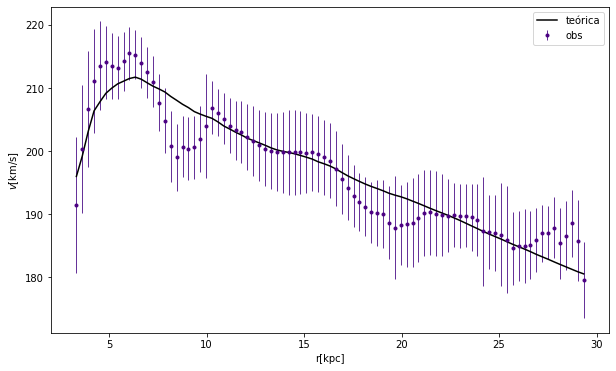

In [6]:
fig = plt.figure(figsize=(10, 6))
#plt.errorbar(mass_models[0].values, total['vrot'].values, yerr=total['err'].values, fmt='.', color='k', elinewidth=1, ecolor='green', label='total')
plt.errorbar(df['Radius'].values, df['vobs'].values, yerr=df['err_vobs'].values, fmt='.', 
             color='indigo', elinewidth=1, ecolor='rebeccapurple', label='obs')
plt.plot(df['Radius'].values, df['Vt'].values, color='k', label='teórica')

plt.ylabel("$v$[km/s]")
plt.xlabel("r[kpc]")
plt.legend()

In [7]:
randomize = np.random.permutation(N)
data = df.values[randomize]

z = data[:,0]
y = data[:,1:3]

In [8]:
scalerz = StandardScaler()
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

In [9]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)
np.shape(z_train), np.shape(y_train), np.shape(z_test), np.shape(y_test)

((69, 1), (69, 2), (18, 1), (18, 2))

In [10]:
def model_regression_dropout(num_hidden):
    # Defeine Keras model for regression
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=num_hidden[1], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=num_hidden[2], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=2, activation="linear"))
    return model

#Define some parameter
batch_size = 4
# optimizer = Adam(lr=.005)
optimizer = Adam(lr=0.0005)


# Compile Keras model
model = model_regression_dropout(num_hidden=[50, 200, 150])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                100       
                                                                 
 MCDropout_1 (MCDropout)     (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 200)               10200     
                                                                 
 MCDropout_2 (MCDropout)     (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 150)               30150     
                                                                 
 MCDropout_3 (MCDropout)     (None, 150)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 3

In [11]:
model.compile(loss='mse', optimizer=optimizer) 
# model2_train = model.fit(zz_train, yy_train, 
# #                          validation_split=0.0, 
#                          batch_size=batch_size, epochs=1000, verbose=1,
#                          validation_data=(zz_test, yy_test))    
model_train = model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=1000,verbose=1,
                                    validation_data=(z_test, y_test))


Epoch 1/1000
18/18 [==============================] - 2s 33ms/step - loss: 19320.4551 - val_loss: 18764.7949
Epoch 2/1000
18/18 [==============================] - 0s 9ms/step - loss: 18681.4180 - val_loss: 17791.0430
Epoch 3/1000
18/18 [==============================] - 0s 9ms/step - loss: 16459.5234 - val_loss: 14590.7764
Epoch 4/1000
18/18 [==============================] - 0s 9ms/step - loss: 11145.6621 - val_loss: 7902.2900
Epoch 5/1000
18/18 [==============================] - 0s 10ms/step - loss: 3553.4556 - val_loss: 1909.5714
Epoch 6/1000
18/18 [==============================] - 0s 9ms/step - loss: 1916.5002 - val_loss: 1638.7969
Epoch 7/1000
18/18 [==============================] - 0s 11ms/step - loss: 1604.3701 - val_loss: 1726.0961
Epoch 8/1000
18/18 [==============================] - 0s 8ms/step - loss: 1232.0853 - val_loss: 1463.3221
Epoch 9/1000
18/18 [==============================] - 0s 9ms/step - loss: 1161.1523 - val_loss: 1330.2423
Epoch 10/1000
18/18 [===============

18/18 [==============================] - 0s 8ms/step - loss: 331.8089 - val_loss: 215.8343
Epoch 79/1000
18/18 [==============================] - 0s 8ms/step - loss: 276.1127 - val_loss: 191.4239
Epoch 80/1000
18/18 [==============================] - 0s 7ms/step - loss: 310.0482 - val_loss: 310.1109
Epoch 81/1000
18/18 [==============================] - 0s 9ms/step - loss: 371.0171 - val_loss: 401.9755
Epoch 82/1000
18/18 [==============================] - 0s 9ms/step - loss: 354.4212 - val_loss: 89.4092
Epoch 83/1000
18/18 [==============================] - 0s 9ms/step - loss: 269.4623 - val_loss: 229.4010
Epoch 84/1000
18/18 [==============================] - 0s 9ms/step - loss: 323.5546 - val_loss: 262.9587
Epoch 85/1000
18/18 [==============================] - 0s 8ms/step - loss: 221.3789 - val_loss: 168.5355
Epoch 86/1000
18/18 [==============================] - 0s 8ms/step - loss: 277.2703 - val_loss: 344.3910
Epoch 87/1000
18/18 [==============================] - 0s 9ms/step - l

18/18 [==============================] - 0s 10ms/step - loss: 227.6621 - val_loss: 274.4171
Epoch 156/1000
18/18 [==============================] - 0s 11ms/step - loss: 145.1064 - val_loss: 246.2168
Epoch 157/1000
18/18 [==============================] - 0s 11ms/step - loss: 159.2215 - val_loss: 148.0745
Epoch 158/1000
18/18 [==============================] - 0s 10ms/step - loss: 188.5280 - val_loss: 242.4089
Epoch 159/1000
18/18 [==============================] - 0s 13ms/step - loss: 162.3770 - val_loss: 241.3662
Epoch 160/1000
18/18 [==============================] - 0s 10ms/step - loss: 191.4368 - val_loss: 107.9616
Epoch 161/1000
18/18 [==============================] - 0s 11ms/step - loss: 162.5536 - val_loss: 175.9451
Epoch 162/1000
18/18 [==============================] - 0s 11ms/step - loss: 133.3318 - val_loss: 194.8485
Epoch 163/1000
18/18 [==============================] - 0s 14ms/step - loss: 166.3595 - val_loss: 118.3605
Epoch 164/1000
18/18 [==============================

18/18 [==============================] - 0s 8ms/step - loss: 157.4365 - val_loss: 128.5759
Epoch 233/1000
18/18 [==============================] - 0s 7ms/step - loss: 204.3254 - val_loss: 117.6868
Epoch 234/1000
18/18 [==============================] - 0s 8ms/step - loss: 192.6239 - val_loss: 155.9637
Epoch 235/1000
18/18 [==============================] - 0s 8ms/step - loss: 182.1219 - val_loss: 122.6380
Epoch 236/1000
18/18 [==============================] - 0s 8ms/step - loss: 154.4146 - val_loss: 191.1742
Epoch 237/1000
18/18 [==============================] - 0s 8ms/step - loss: 139.0708 - val_loss: 169.1127
Epoch 238/1000
18/18 [==============================] - 0s 8ms/step - loss: 146.1140 - val_loss: 73.6790
Epoch 239/1000
18/18 [==============================] - 0s 8ms/step - loss: 180.0352 - val_loss: 195.7919
Epoch 240/1000
18/18 [==============================] - 0s 8ms/step - loss: 214.9953 - val_loss: 108.7703
Epoch 241/1000
18/18 [==============================] - 0s 8ms

18/18 [==============================] - 0s 11ms/step - loss: 137.9485 - val_loss: 211.4378
Epoch 310/1000
18/18 [==============================] - 0s 10ms/step - loss: 207.2305 - val_loss: 166.0191
Epoch 311/1000
18/18 [==============================] - 0s 12ms/step - loss: 136.1155 - val_loss: 108.6873
Epoch 312/1000
18/18 [==============================] - 0s 10ms/step - loss: 148.8763 - val_loss: 150.8407
Epoch 313/1000
18/18 [==============================] - 0s 10ms/step - loss: 172.9100 - val_loss: 121.5910
Epoch 314/1000
18/18 [==============================] - 0s 10ms/step - loss: 124.9217 - val_loss: 151.6727
Epoch 315/1000
18/18 [==============================] - 0s 12ms/step - loss: 167.3327 - val_loss: 227.4323
Epoch 316/1000
18/18 [==============================] - 0s 11ms/step - loss: 168.4900 - val_loss: 131.8080
Epoch 317/1000
18/18 [==============================] - 0s 8ms/step - loss: 192.1530 - val_loss: 240.1119
Epoch 318/1000
18/18 [==============================]

18/18 [==============================] - 0s 10ms/step - loss: 165.0024 - val_loss: 112.4731
Epoch 387/1000
18/18 [==============================] - 0s 9ms/step - loss: 138.1269 - val_loss: 195.5206
Epoch 388/1000
18/18 [==============================] - 0s 11ms/step - loss: 121.7845 - val_loss: 148.2434
Epoch 389/1000
18/18 [==============================] - 0s 9ms/step - loss: 131.4892 - val_loss: 114.3846
Epoch 390/1000
18/18 [==============================] - 0s 9ms/step - loss: 152.8078 - val_loss: 159.3745
Epoch 391/1000
18/18 [==============================] - 0s 10ms/step - loss: 138.2144 - val_loss: 244.6724
Epoch 392/1000
18/18 [==============================] - 0s 11ms/step - loss: 110.3030 - val_loss: 119.4030
Epoch 393/1000
18/18 [==============================] - 0s 12ms/step - loss: 137.9110 - val_loss: 101.0196
Epoch 394/1000
18/18 [==============================] - 0s 12ms/step - loss: 166.3366 - val_loss: 121.8476
Epoch 395/1000
18/18 [==============================] -

18/18 [==============================] - 0s 9ms/step - loss: 166.8589 - val_loss: 80.3013
Epoch 464/1000
18/18 [==============================] - 0s 9ms/step - loss: 131.8053 - val_loss: 133.8104
Epoch 465/1000
18/18 [==============================] - 0s 8ms/step - loss: 148.2738 - val_loss: 198.7006
Epoch 466/1000
18/18 [==============================] - 0s 7ms/step - loss: 148.5130 - val_loss: 86.3203
Epoch 467/1000
18/18 [==============================] - 0s 6ms/step - loss: 120.3165 - val_loss: 137.2986
Epoch 468/1000
18/18 [==============================] - 0s 8ms/step - loss: 141.8025 - val_loss: 181.7332
Epoch 469/1000
18/18 [==============================] - 0s 8ms/step - loss: 130.6481 - val_loss: 93.8103
Epoch 470/1000
18/18 [==============================] - 0s 8ms/step - loss: 131.0409 - val_loss: 111.1213
Epoch 471/1000
18/18 [==============================] - 0s 8ms/step - loss: 143.7145 - val_loss: 158.7972
Epoch 472/1000
18/18 [==============================] - 0s 8ms/s

18/18 [==============================] - 0s 14ms/step - loss: 159.2003 - val_loss: 142.1322
Epoch 541/1000
18/18 [==============================] - 0s 11ms/step - loss: 145.9673 - val_loss: 127.5014
Epoch 542/1000
18/18 [==============================] - 0s 10ms/step - loss: 173.3997 - val_loss: 99.5860
Epoch 543/1000
18/18 [==============================] - 0s 10ms/step - loss: 140.1750 - val_loss: 109.0644
Epoch 544/1000
18/18 [==============================] - 0s 9ms/step - loss: 172.4179 - val_loss: 170.2996
Epoch 545/1000
18/18 [==============================] - 0s 10ms/step - loss: 115.4178 - val_loss: 169.8745
Epoch 546/1000
18/18 [==============================] - 0s 10ms/step - loss: 136.4529 - val_loss: 106.7517
Epoch 547/1000
18/18 [==============================] - 0s 9ms/step - loss: 131.6448 - val_loss: 131.1842
Epoch 548/1000
18/18 [==============================] - 0s 10ms/step - loss: 142.5036 - val_loss: 232.9183
Epoch 549/1000
18/18 [==============================] -

18/18 [==============================] - 0s 9ms/step - loss: 155.9377 - val_loss: 69.0780
Epoch 618/1000
18/18 [==============================] - 0s 8ms/step - loss: 155.8059 - val_loss: 206.6775
Epoch 619/1000
18/18 [==============================] - 0s 9ms/step - loss: 149.7516 - val_loss: 207.7561
Epoch 620/1000
18/18 [==============================] - 0s 9ms/step - loss: 135.2663 - val_loss: 152.7353
Epoch 621/1000
18/18 [==============================] - 0s 9ms/step - loss: 187.5725 - val_loss: 169.3646
Epoch 622/1000
18/18 [==============================] - 0s 10ms/step - loss: 133.7608 - val_loss: 161.7550
Epoch 623/1000
18/18 [==============================] - 0s 9ms/step - loss: 127.5934 - val_loss: 144.5518
Epoch 624/1000
18/18 [==============================] - 0s 10ms/step - loss: 143.5190 - val_loss: 223.4136
Epoch 625/1000
18/18 [==============================] - 0s 9ms/step - loss: 190.6598 - val_loss: 136.6338
Epoch 626/1000
18/18 [==============================] - 0s 1

18/18 [==============================] - 0s 8ms/step - loss: 127.4686 - val_loss: 167.1473
Epoch 695/1000
18/18 [==============================] - 0s 9ms/step - loss: 166.3623 - val_loss: 137.9872
Epoch 696/1000
18/18 [==============================] - 0s 8ms/step - loss: 145.5527 - val_loss: 120.9478
Epoch 697/1000
18/18 [==============================] - 0s 7ms/step - loss: 147.5755 - val_loss: 188.9313
Epoch 698/1000
18/18 [==============================] - 0s 8ms/step - loss: 122.0402 - val_loss: 190.3884
Epoch 699/1000
18/18 [==============================] - 0s 9ms/step - loss: 142.1326 - val_loss: 174.8438
Epoch 700/1000
18/18 [==============================] - 0s 10ms/step - loss: 147.7592 - val_loss: 97.7745
Epoch 701/1000
18/18 [==============================] - 0s 9ms/step - loss: 122.9387 - val_loss: 97.3884
Epoch 702/1000
18/18 [==============================] - 0s 8ms/step - loss: 121.2575 - val_loss: 84.3428
Epoch 703/1000
18/18 [==============================] - 0s 8ms/

18/18 [==============================] - 0s 7ms/step - loss: 116.5986 - val_loss: 51.7752
Epoch 772/1000
18/18 [==============================] - 0s 8ms/step - loss: 172.6900 - val_loss: 71.0228
Epoch 773/1000
18/18 [==============================] - 0s 8ms/step - loss: 171.0212 - val_loss: 131.4541
Epoch 774/1000
18/18 [==============================] - 0s 8ms/step - loss: 158.2340 - val_loss: 150.0724
Epoch 775/1000
18/18 [==============================] - 0s 7ms/step - loss: 118.9145 - val_loss: 147.8323
Epoch 776/1000
18/18 [==============================] - 0s 8ms/step - loss: 190.3382 - val_loss: 138.6431
Epoch 777/1000
18/18 [==============================] - 0s 9ms/step - loss: 149.7683 - val_loss: 257.2182
Epoch 778/1000
18/18 [==============================] - 0s 7ms/step - loss: 123.2254 - val_loss: 97.2529
Epoch 779/1000
18/18 [==============================] - 0s 8ms/step - loss: 138.9783 - val_loss: 108.6156
Epoch 780/1000
18/18 [==============================] - 0s 8ms/s

18/18 [==============================] - 0s 10ms/step - loss: 110.6116 - val_loss: 160.5843
Epoch 849/1000
18/18 [==============================] - 0s 8ms/step - loss: 135.3320 - val_loss: 98.4856
Epoch 850/1000
18/18 [==============================] - 0s 9ms/step - loss: 177.1962 - val_loss: 171.7077
Epoch 851/1000
18/18 [==============================] - 0s 9ms/step - loss: 140.6982 - val_loss: 63.7710
Epoch 852/1000
18/18 [==============================] - 0s 11ms/step - loss: 113.2271 - val_loss: 130.4930
Epoch 853/1000
18/18 [==============================] - 0s 10ms/step - loss: 118.2775 - val_loss: 154.8095
Epoch 854/1000
18/18 [==============================] - 0s 10ms/step - loss: 99.2311 - val_loss: 113.7051
Epoch 855/1000
18/18 [==============================] - 0s 10ms/step - loss: 217.0631 - val_loss: 70.7627
Epoch 856/1000
18/18 [==============================] - 0s 9ms/step - loss: 103.3426 - val_loss: 118.7938
Epoch 857/1000
18/18 [==============================] - 0s 1

18/18 [==============================] - 0s 11ms/step - loss: 156.3042 - val_loss: 133.6158
Epoch 926/1000
18/18 [==============================] - 0s 11ms/step - loss: 123.3016 - val_loss: 154.3806
Epoch 927/1000
18/18 [==============================] - 0s 11ms/step - loss: 138.5882 - val_loss: 102.4879
Epoch 928/1000
18/18 [==============================] - 0s 9ms/step - loss: 120.2442 - val_loss: 110.0792
Epoch 929/1000
18/18 [==============================] - 0s 10ms/step - loss: 192.2318 - val_loss: 106.0777
Epoch 930/1000
18/18 [==============================] - 0s 9ms/step - loss: 140.4088 - val_loss: 176.5745
Epoch 931/1000
18/18 [==============================] - 0s 10ms/step - loss: 132.7259 - val_loss: 130.6286
Epoch 932/1000
18/18 [==============================] - 0s 11ms/step - loss: 149.1125 - val_loss: 124.6075
Epoch 933/1000
18/18 [==============================] - 0s 11ms/step - loss: 134.2265 - val_loss: 105.3372
Epoch 934/1000
18/18 [==============================] 

In [12]:
model_train.history['val_loss'][-1]

170.47474670410156

In [19]:
# Generate test data
test_batch_size = 500
# x_test = np.random.uniform(0, 2., test_batch_size)
x_test = np.linspace(min(df['Radius'].values)-0.1, max(df['Radius'].values)+0.1, test_batch_size)

mc_dropout_num = 100  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)



16/16 [==============================] - 0s 5ms/step


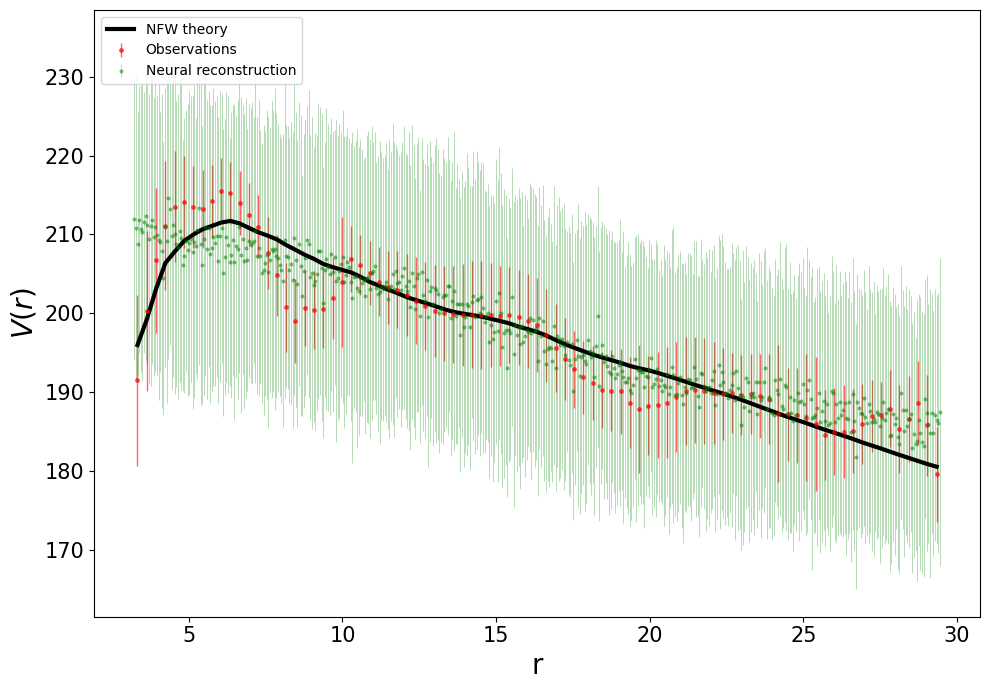

In [20]:
# plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
overlapping = 0.6
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)



plt.plot(df['Radius'].values, df['Vt'].values, color='k', linewidth=3, label='NFW theory',alpha=1)

plt.errorbar(df['Radius'].values, df['vobs'].values, yerr=df['err_vobs'].values, fmt='.', 
             color='red', elinewidth=1, ecolor='red', markersize=5, label='Observations', alpha=overlapping)

plt.errorbar(x_test, prediction_mc_dropout[:,0], yerr=sigma, markersize=2, fmt='o', 
             ecolor='green', capthick=2, elinewidth=0.5, alpha=overlapping-0.2, c='green',
             label='Neural reconstruction')


plt.ylabel("$V(r)$", fontsize=20)
plt.xlabel("r", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(loc='upper left')
plt.tight_layout()

plt.savefig("neural_reconstruction_RC.png", dpi=100)

(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

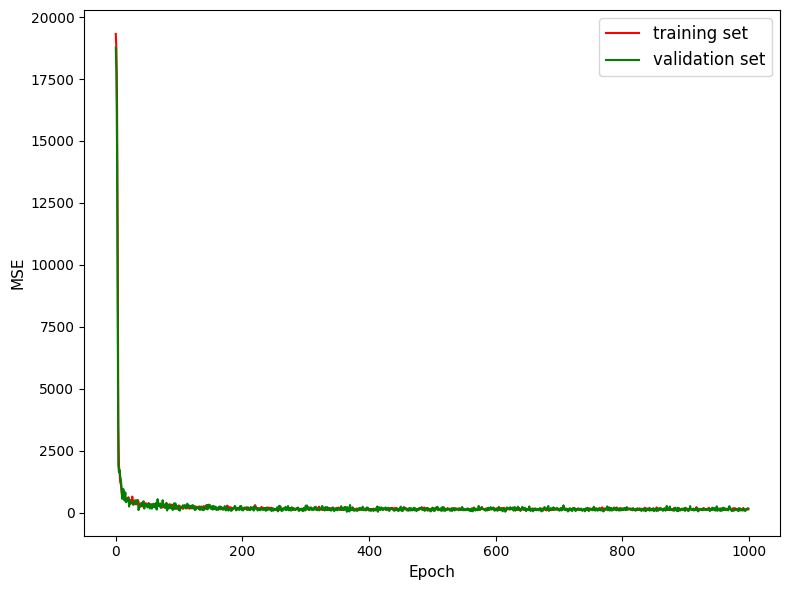

In [18]:
plt.figure(figsize=(8, 6), dpi=100)

plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
plt.xticks(fontsize=10)
# plt.ylim(0, 200)